# Modell zur Bachelorarbeit

### Einrichtung

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math

import pypsa
import pypsa.plot as bmplot

%matplotlib inline

## Setup

Einrichtung aller wichtigen Kompnenten und Einlesen der Daten

Die jeweiligen Daten sind rein fiktiv und dienen lediglich dem Testen der einzelnen Code-Abschnitte. Später werden reale Daten aus einer anderen Bachelorarbeit verwendet.

### Variablen

In [2]:
nw = pypsa.Network()

In [3]:
dates = pd.date_range("20170101", periods=6, freq="4H")

nw.set_snapshots(dates)

### Einlesen der Datenbanken

In [4]:
cur_path = r"C:\Users\janni\OneDrive\TU Berlin\4 - Abschlussarbeiten\01 - Bachelorarbeit\modell\data\\"

In [5]:
components = [pd.DataFrame for i in range(4)]
filenames = ["vertices", "lines", "unit_data_twogen","loads"]
units = ["Bus", "Line", "Generator", "Load"]

Einlesen der als *.csv gespeicherten Daten in ein pandas DataFrame, alle NaN werden durch 0 ersetzt

In [6]:
for i in range(len(components)):
    components[i] = pd.read_csv(cur_path + filenames[i] + ".csv")
    components[i].fillna(0,inplace=True)

Umbenennung aller Spaltennamen, die nicht dem von PyPSA vorgegebenen Namen entsprechen

In [7]:
components[1].rename(columns={"wid":"x","len":"length","cap":"s_nom"},inplace=True)
components[2].rename(columns={"marg. Cost":"marginal_cost","min power":"p_min_pu","startup costs":"start_up_cost","nom power":"p_nom"},inplace=True)

Das eigentliche Erstellen der Komponenten des Modells. Dies geschieht über die von PyPSA dafür vorgesehene Methode "import_components_from_dataframe"

In [8]:
for i in range(len(components)):
    pypsa.io.import_components_from_dataframe(nw, components[i], units[i])

Aus der genannten Datei werden die zeitlichen Veränderungen der Lasten nach Zeitintervallen eingelesen

In [9]:
# dates = pd.date_range("20170101", periods=6, freq="4H")

df = pd.DataFrame(pd.read_csv(cur_path + "load_dist2" + ".csv"))
df.index = dates
nw.import_series_from_dataframe(df, "Load", "p_set")

In [10]:
nw.generators.T

,0,1,2
name,Wind Offshore,Gasturbine,GuD
bus,3,1,2
committable,True,True,True
carrier,wind,gas,gas
marginal_cost,5,50,35
p_min_pu,0,0.2,0.2
start_up_cost,0,5000,6000
p_nom,75,200,200
efficiency,0.45,0.38,0.6
control,PQ,PQ,PQ


## Optimierung

In [12]:
nw.lopf(solver_name="gurobi")

INFO:pypsa.pf:Slack bus for sub-network 0 is 3
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x97
  Lower bound: 51485.0
  Upper bound: 51485.0
  Number of objectives: 1
  Number of constraints: 151
  Number of variables: 97
  Number of binary variables: 18
  Number of integer variables: 18
  Number of continuous variables: 79
  Number of nonzeros: 293
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimalit

('ok', 'optimal')

## Aufbereitung der Daten

Das Berechnen und Vorbereiten einiger Variablen, um diese später eleganter in Diagrammen darstellen zu können

In [13]:
gen_outs = nw.generators_t.p
caps_by_carrier = nw.generators.groupby("carrier")["p_nom"].sum()
gen_pot_remaining = nw.generators.p_nom - gen_outs

## Visualisierung

Diagramm, das die eingespeiste Energie je Kraftwerk nach Zeitabschnitten anzeigt.

Text(0,0.5,'MW')

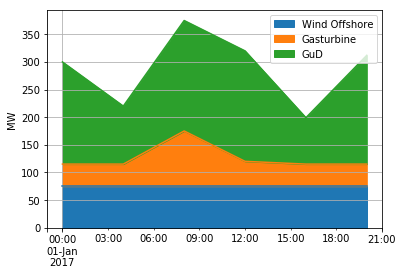

In [14]:
gen_plot = gen_outs.plot(kind="area",grid=True)
lines, labels = gen_plot.get_legend_handles_labels()
gen_plot.legend(lines[:len(nw.generators)], components[2]['name'].values.tolist(), loc='best')
plt.ylabel("MW")

Simple Darstellung des Netzaufbaus unter Verwendung der von PyPSA eigens bereitgestellten Methode

(0, 120)

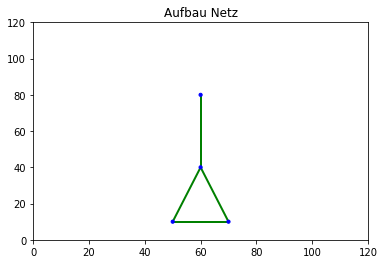

In [15]:
bmplot.plot(nw, title="Aufbau Netz")
plt.xlim([0,120])
plt.ylim([0,120])